In [2]:
import shap
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
# 显示中文
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif'] = ['times new roman']
matplotlib.rcParams['axes.unicode_minus'] = False

c:\Users\lfq\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 读取数据

In [3]:
# 读取数据
data = pd.read_csv(r"D:\新建文件夹\国地杯\遥感\合并输出\内流区\内流区_2020.csv")  # 假设数据存储在data.csv文件
print(data.head())  # 打印数据的前几行以检查数据格式    

   grid_id        ET0        DI        AP        AAT        ATR            SR  \
0        0  27.397708 -1.561101  0.183878 -13.325925  12.441744  8.321203e+09   
1        1  24.125937  0.003295  0.170588 -12.371602  12.906586  8.316414e+09   
2        2  25.460208 -0.393542  0.179993 -12.726423  12.572965  8.308050e+09   
3        3  28.830938 -0.495979  0.173254 -11.921846  12.869923  8.292034e+09   
4        4  27.943750  0.443750  0.176530 -11.892277  13.320703  8.257802e+09   

         SM       FVC  
0  0.159919  0.185536  
1  0.164756  0.175939  
2  0.163520  0.144024  
3  0.161827  0.202466  
4  0.272350  0.227902  


# 数据预处理

In [4]:
# 特征数据,假设除了第一列和最后一列是特征
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]  # 目标数据,假设最后一列是目标变量

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练XGBboost模型

In [ ]:
# 训练XGBoost模型
model = xgb.XGBRegressor(objective='reg:squarederror',  # 回归问题
                         n_estimators=2000,             # 树的数量
                         max_depth=4,                   # 树的最大深度
                         learning_rate=0.03,            # 学习率
                         gamma=0,                       # 用于kongzhi是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                         min_child_weight=3.6,          # 定义最小叶子节点样本权重和，如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
                         subsample=0.56,                # 随机采样训练样本
                         colsample_bytree=0.8,          # 生成树时进行的列采样
                         reg_lambda=60,                 # kongzhi模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                         reg_alpha=0.1,                 # kongzhi模型复杂度的权重值的L1正则化项参数，参数越大，模型越不容易过拟合。
                         reg_state=1,                   # 正则化项参数
)
model.fit(X_train, y_train)


c:\Users\lfq\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:39:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "reg_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|===================| 2116/2124 [01:09<00:00]        

训练集R²分数: 0.8709759509133503
测试集R²分数: 0.7936429066843185
训练集指标：
MAE = 0.006
RMSE = 0.006
MAPE = 19.45%
NSE = 0.871
KGE = 0.831
PBIAS = 0.005%

测试集指标：
MAE = 0.067
RMSE = 0.095
MAPE = 25.36%
NSE = 0.794
KGE = 0.831
PBIAS = -0.166%


In [ ]:

# 计算SHAP值
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
from sklearn.metrics import r2_score

# 预测测试集
y_pred = model.predict(X_test)

# 预测训练集
y_train_pred = model.predict(X_train)

# 计算R²分数
print("训练集R²分数:", r2_score(y_train, y_train_pred))
print("测试集R²分数:", r2_score(y_test, y_pred))
# 计算残差
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 测试集MAE
mae = mean_absolute_error(y_test, y_pred)
# 训练集MAE
mae_train = mean_absolute_error(y_train, y_train_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae_train = mean_squared_error(y_train, y_train_pred)


# 测试集MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# 训练集MAPE
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# NSE
nse = 1 - np.sum((y_pred - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
# 训练集NSE
nse_train = 1 - np.sum((y_train_pred - y_train) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)

# Pearson 相关系数 r
r = np.corrcoef(y_test, y_pred)[0, 1]

# KGE
alpha = np.std(y_pred) / np.std(y_test)
beta = np.mean(y_pred) / np.mean(y_test)
kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
# 训练集KGE
alpha_train = np.std(y_train_pred) / np.std(y_train)
beta_train = np.mean(y_train_pred) / np.mean(y_train)
kge_train = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# PBIAS
pbias = 100 * np.sum(y_pred - y_test) / np.sum(y_test)
# 训练集PBIAS
pbias_train = 100 * np.sum(y_train_pred - y_train) / np.sum(y_train)

# 输出所有指标
print("训练集指标：")
print(f"MAE = {mae_train:.3f}")
print(f"RMSE = {mae_train:.3f}")


print("\n测试集指标：")
print(f"MAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")



 98%|===================| 2088/2124 [00:52<00:00]        

训练集R²分数: 0.8709759509133503


ValueError: Found input variables with inconsistent numbers of samples: [3000, 2124]

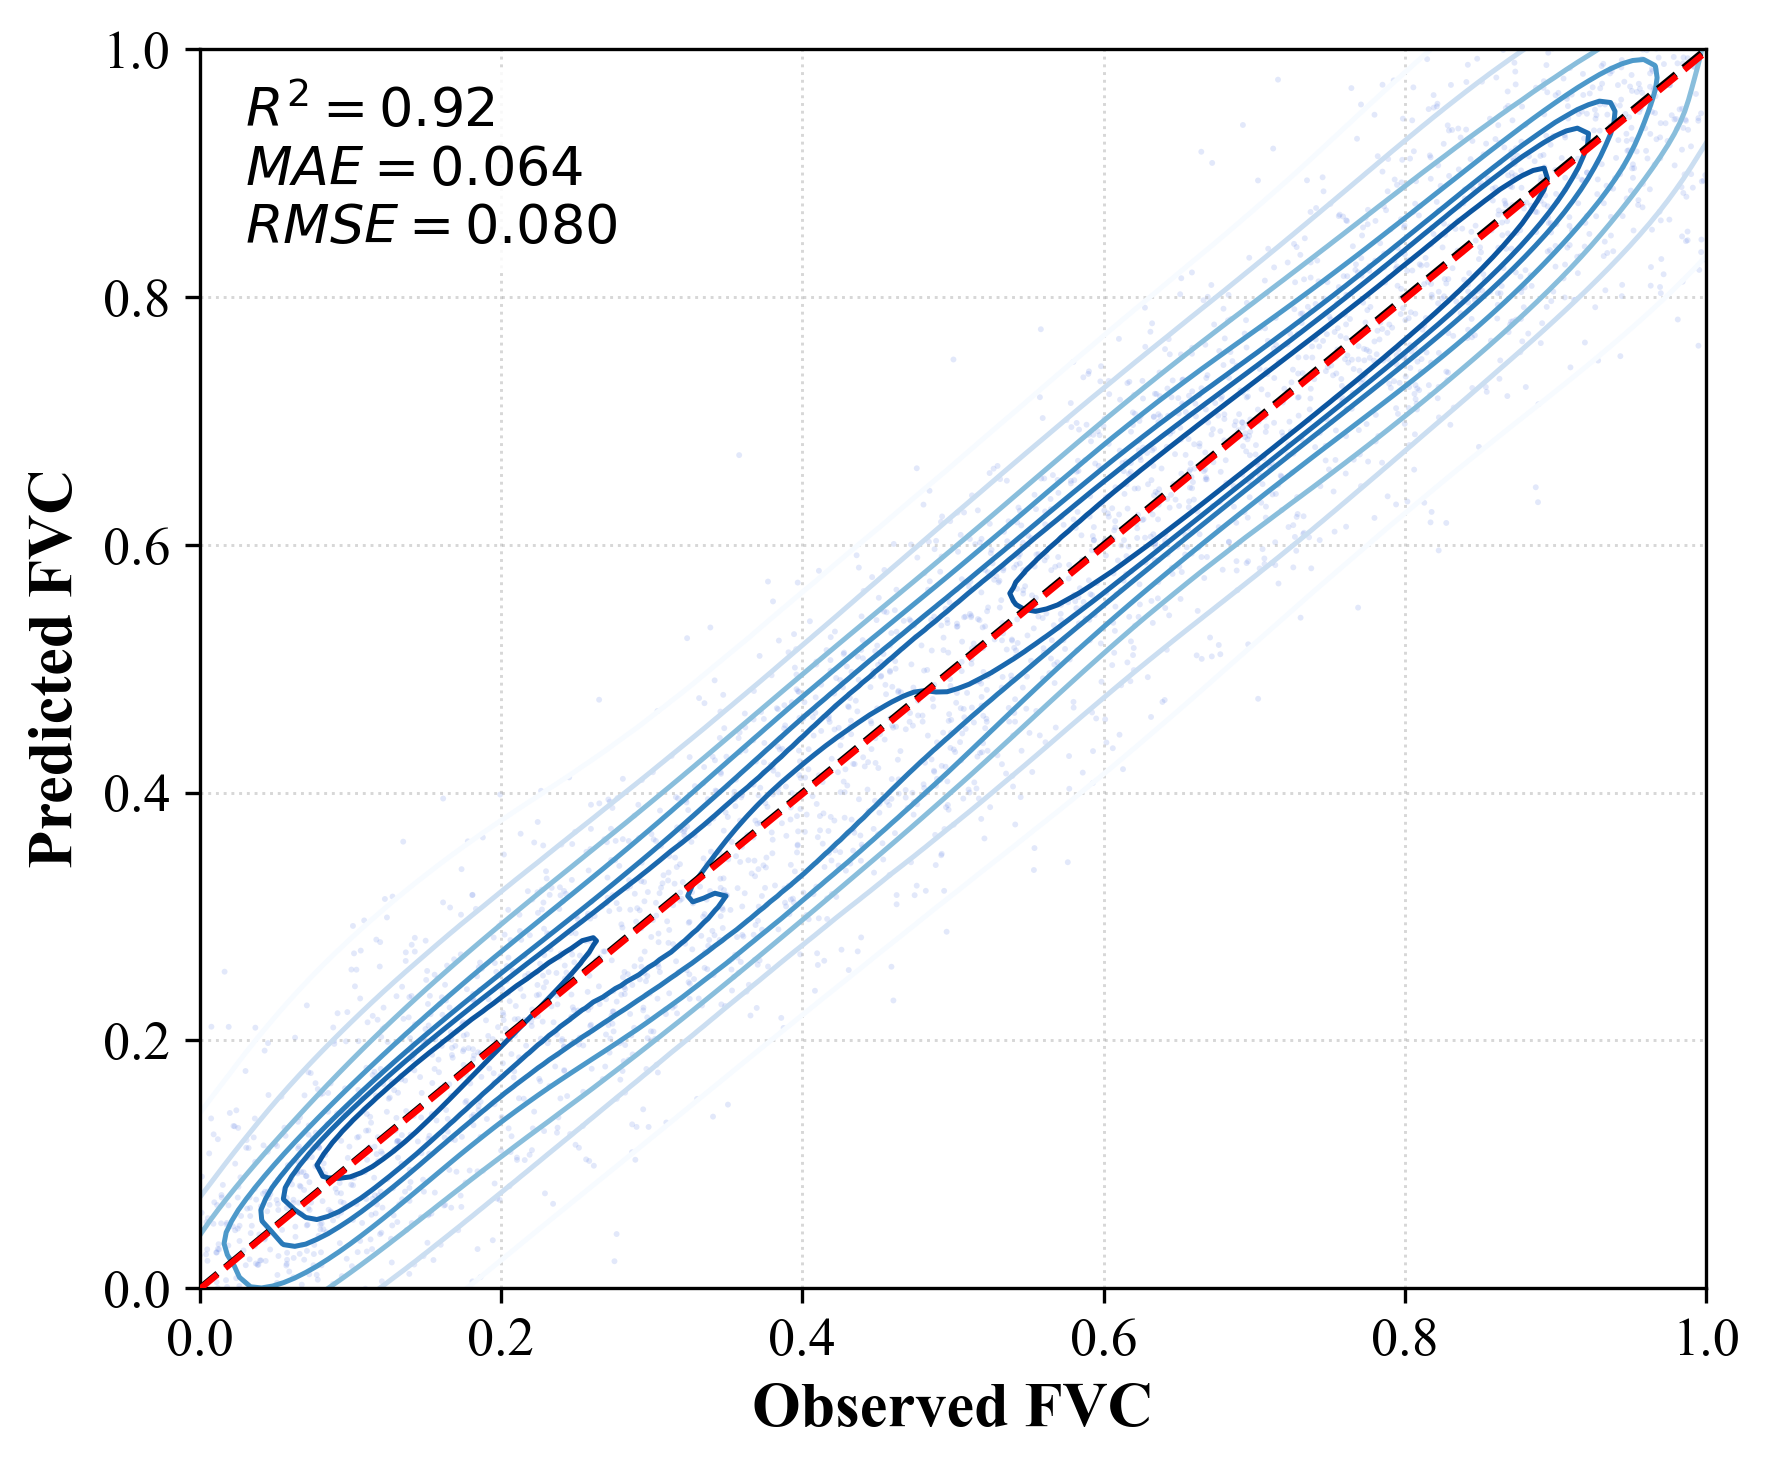

In [ ]:
# 可视化函数：柱状图对比训练集和测试集指标
def plot_metrics_bar():
    metrics = ['R²', 'MAE', 'RMSE']
    train_values = [r2_train, mae_train, rmse_train]
    test_values = [r2_test, mae_test, rmse_test]

    x = np.arange(len(metrics))  # 标签位置
    width = 0.35  # 柱状图宽度

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='训练集')
    rects2 = ax.bar(x + width/2, test_values, width, label='测试集')

    # 添加标签、标题和自定义x轴刻度
    ax.set_ylabel('指标值', fontsize=12)
    ax.set_title('模型评估指标对比', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend()

    # 在柱状图上添加数值标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3点垂直偏移
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()


# 可视化函数：雷达图展示各指标（更直观展示整体表现）
def plot_metrics_radar():
    # 对R²进行归一化处理（因为R²最大值为1，其他指标越小越好）
    # 这里将误差指标转换为1/(1+指标)以便在雷达图上统一方向
    metrics = ['R²', 'MAE', 'RMSE']
    
    # 训练集指标处理
    train_norm = [
        r2_train,  # R²直接使用
        1/(1+mae_train),  # MAE归一化（值越大越好）
        1/(1+rmse_train)  # RMSE归一化（值越大越好）
    ]
    
    # 测试集指标处理
    test_norm = [
        r2_test,
        1/(1+mae_test),
        1/(1+rmse_test)
    ]

    # 计算角度
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    train_norm = train_norm + [train_norm[0]]
    test_norm = test_norm + [test_norm[0]]
    angles = angles + [angles[0]]

    # 绘制雷达图
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, train_norm, color='b', alpha=0.25, label='训练集')
    ax.plot(angles, train_norm, color='b', linewidth=2)
    ax.fill(angles, test_norm, color='r', alpha=0.25, label='测试集')
    ax.plot(angles, test_norm, color='r', linewidth=2)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1.1)  # 设置y轴范围
    ax.set_title('模型评估指标雷达图', fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


# 调用可视化函数
plot_metrics_bar()
plot_metrics_radar()

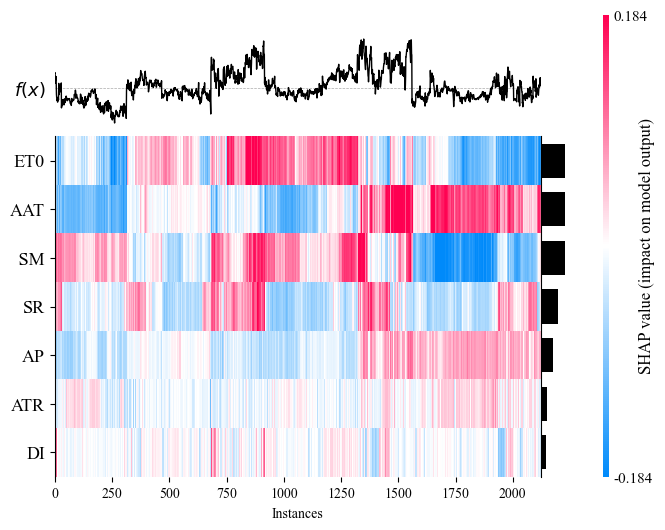

In [ ]:
shap.plots.heatmap(shap_values,show=False)
# 保存图像
plt.savefig('heatmap.png')
plt.show()

# 峰群图

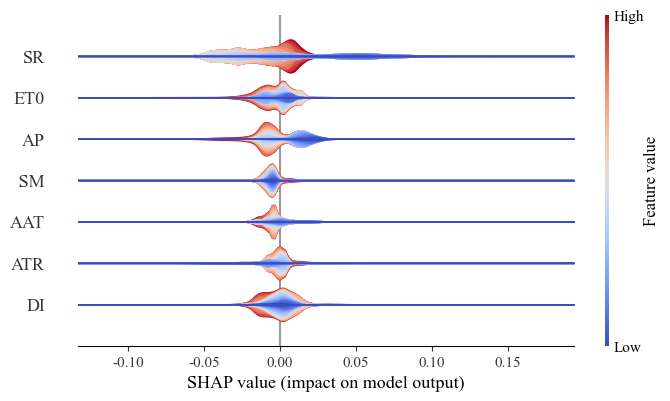

In [ ]:
plt.rcParams['font.sans-serif'] = ['times new roman']  # 使用中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 确保坐标轴负号显示正常
shap.plots.violin(shap_values, plot_type="layered_violin", show=False)
# 保存图像 
#plt.savefig(r"D:\新建文件夹\遥感\图\小提琴图\沙漠\2020.png", dpi=400, bbox_inches='tight')

# 特征重要性条形图

C:\Users\35333\AppData\Local\Temp\ipykernel_3640\931978560.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


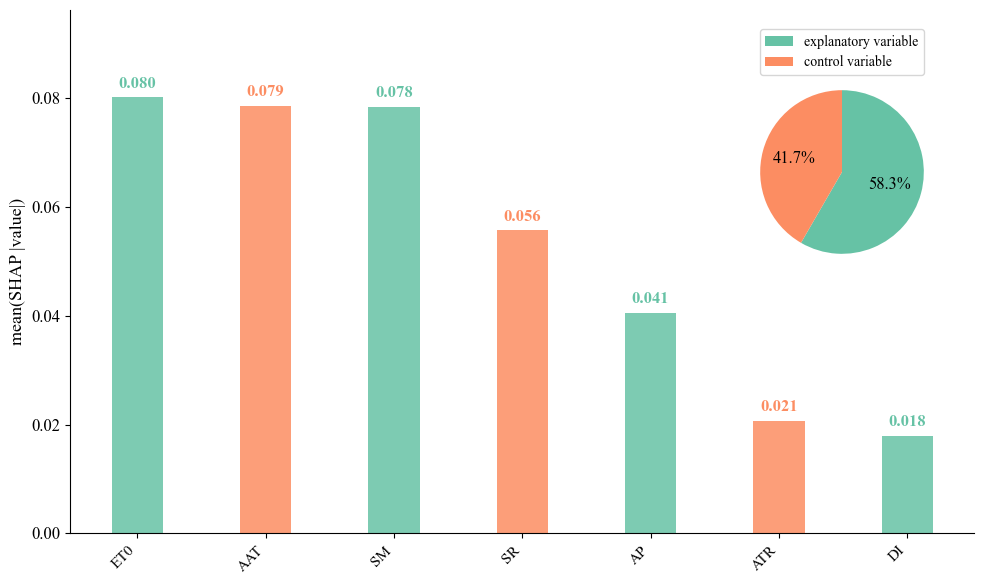

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.patches import Patch

# 设置字体和中文显示
plt.rcParams['font.sans-serif'] = ['宋体']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 提取 SHAP 值
if hasattr(shap_values, 'values'):
    values = shap_values.values[0] if isinstance(shap_values.values, list) else shap_values.values
elif hasattr(shap_values, 'data'):
    values = shap_values.data
else:
    values = np.array(shap_values)

# 计算平均 SHAP 值
feature_importance = np.abs(values).mean(0)
feature_names = [name.strip() for name in X_train.columns]

# 特征分类映射（按前缀）
group_mapping = {
    "AP": "explanatory variable",  
    "AAT": "control variable",
    "ATR": "control variable", 
    "SR": "control variable",
    "SM": "explanatory variable",
    "ET0": "explanatory variable",
    "DI": "explanatory variable",
}

# 分类颜色
category_colors = {
    "explanatory variable": "#66c2a5",  
    "control variable": "#fc8d62"
}

# 特征 → 分类映射
feature_categories = {}
for name in feature_names:
    prefix = next((p for p in group_mapping if name.startswith(p)), None)
    if prefix:
        feature_categories[name] = group_mapping[prefix]

# 保留分类明确的特征
valid_indices = [i for i, name in enumerate(feature_names) if name in feature_categories]
valid_names = [feature_names[i] for i in valid_indices]
valid_importance = [feature_importance[i] for i in valid_indices]

# 从高到低排序
sorted_pairs = sorted(zip(valid_names, valid_importance), key=lambda x: x[1], reverse=True)
sorted_names = [x[0] for x in sorted_pairs]
sorted_importance = [x[1] for x in sorted_pairs]

# 创建图像和子图
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(sorted_names))

# 设置较细的柱宽度
bar_width = 0.4

# 绘制柱状图
bars = []
for i, (name, importance) in enumerate(zip(sorted_names, sorted_importance)):
    cat = feature_categories[name]
    color = category_colors[cat]
    bar = ax.bar(i, importance, color=color, width=bar_width, alpha=0.85)
    bars.append(bar)
    # 添加数值标注
    ax.text(i, importance + 0.001, f'{importance:.3f}', ha='center', va='bottom', color=color, fontweight='bold')

# 坐标轴设置
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('mean(SHAP |value|)', fontsize=13)
ax.set_ylim(0, max(sorted_importance) * 1.2)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# 饼图数据统计
category_total = {"explanatory variable": 0, "control variable": 0}
for name, imp in zip(valid_names, valid_importance):
    cat = feature_categories[name]
    category_total[cat] += imp

categories = list(category_total.keys())
values = list(category_total.values())
colors = [category_colors[c] for c in categories]

# 饼图（右上角）
ax_pie = fig.add_axes([0.7, 0.55, 0.3, 0.3])
wedges, texts, autotexts = ax_pie.pie(values, colors=colors, autopct='%1.1f%%',
                                      startangle=90, counterclock=False)
ax_pie.axis('equal')


# 保留饼图下方图例（恢复原风格）
legend_handles = [Patch(facecolor=category_colors[c], label=c) for c in categories]
ax_pie.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, 1),
              fontsize=10, frameon=True)

# 自动布局
plt.tight_layout()
#保存图片
#plt.savefig(r'D:\新建文件夹\遥感\图\特征重要性图\沙漠\2000', dpi=400, bbox_inches='tight')
plt.show()


# 主效应

# 整图

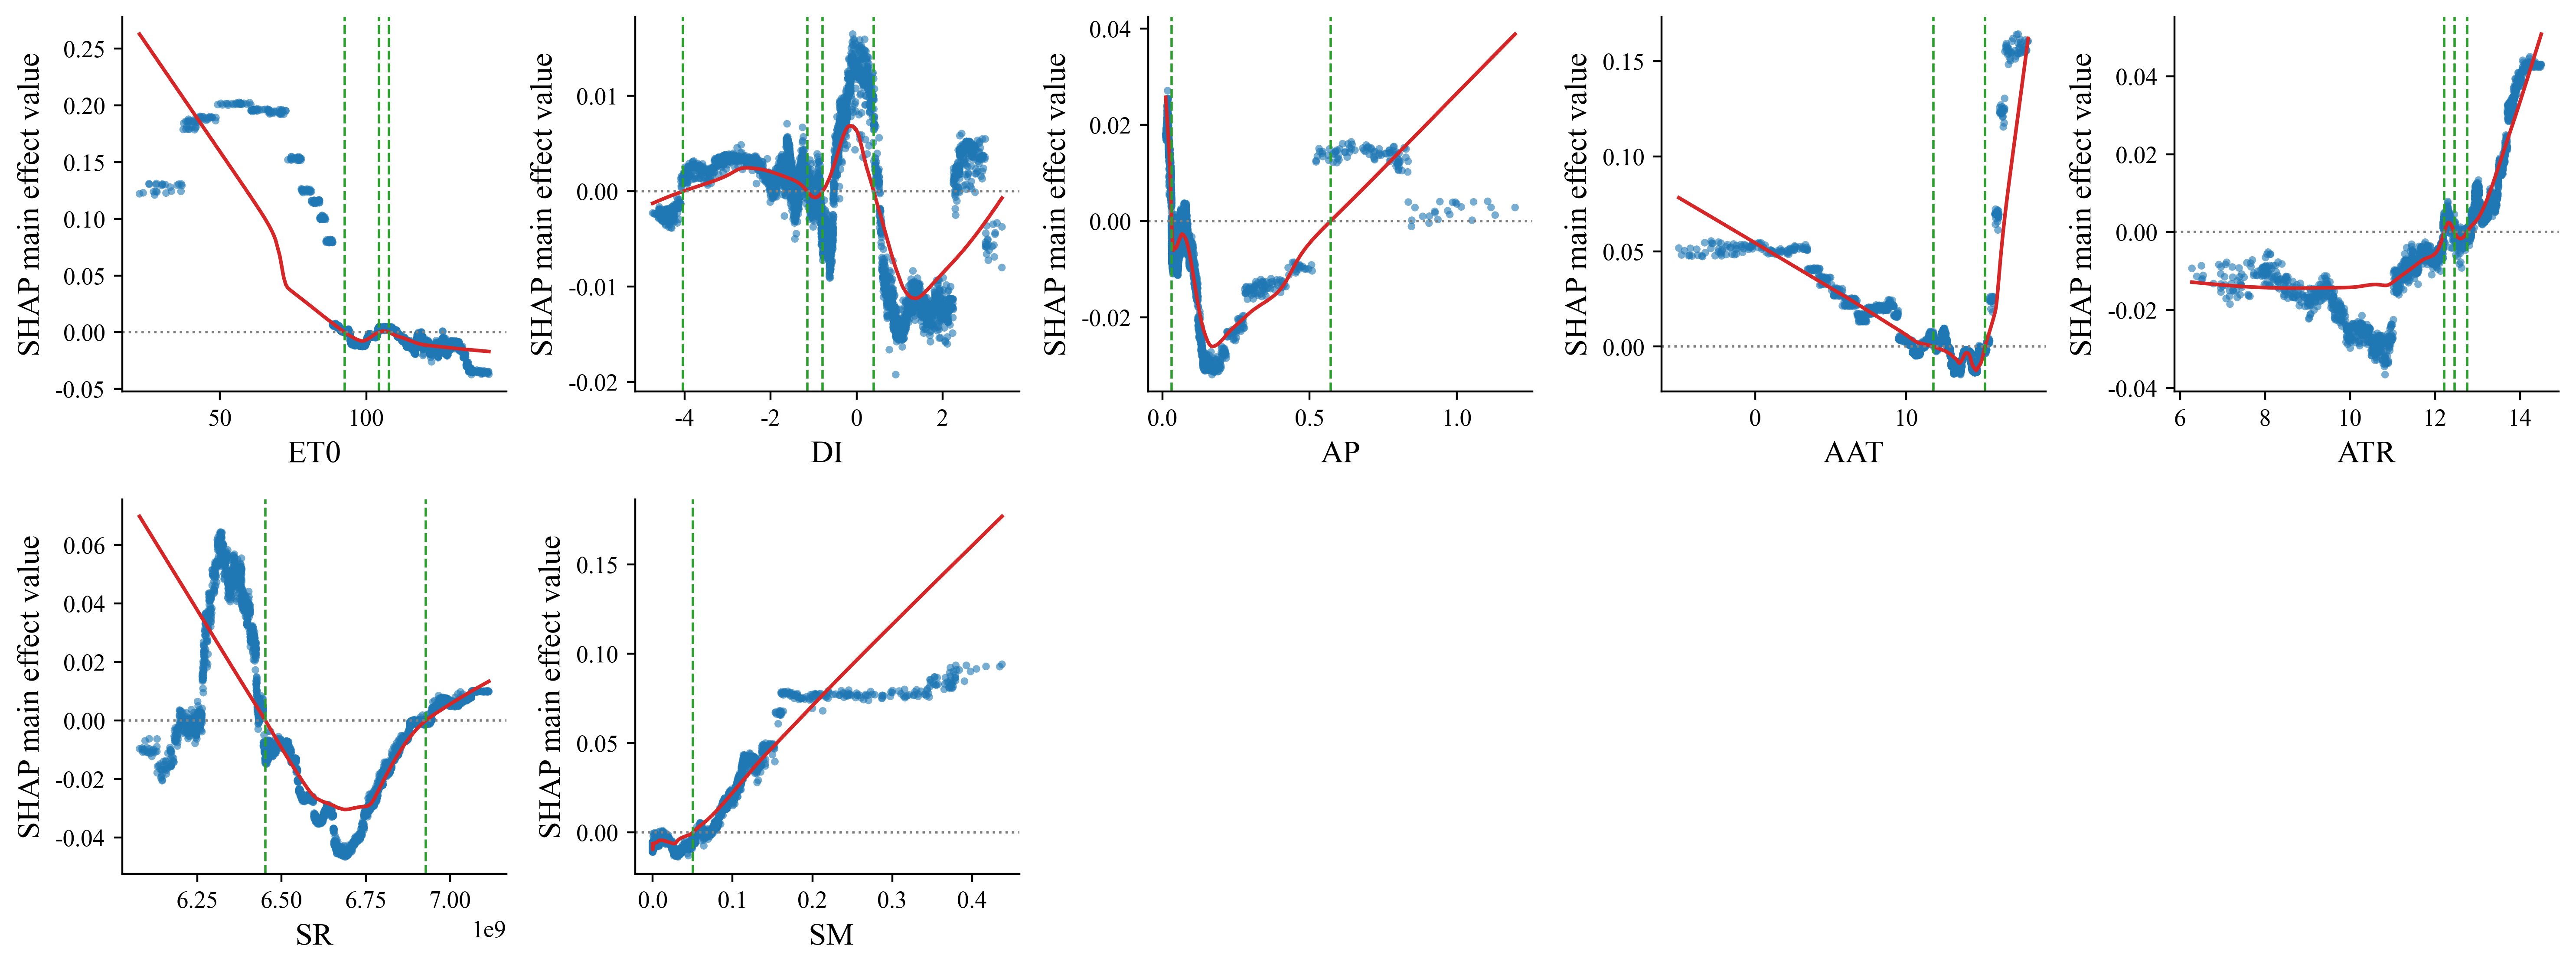

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import rcParams


# 设置全局字体与样式
plt.style.use('default')
rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.unicode_minus': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
explainer = shap.TreeExplainer(model)
# 主效应计算
shap_interaction_values = explainer.shap_interaction_values(X_train) 
main_effects = np.array([shap_interaction_values[:, i, i] for i in range(shap_interaction_values.shape[1])]).T
main_effects_df = pd.DataFrame(main_effects, columns=X_train.columns)

# 子图设置
num_rows, num_cols = 3, 5
features = main_effects_df.columns[:num_rows * num_cols]
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8), dpi=400)

def find_zero_crossings(x_fit, y_fit):
    crossings = []
    for i in range(1, len(y_fit)):
        if (y_fit[i-1] < 0 and y_fit[i] > 0) or (y_fit[i-1] > 0 and y_fit[i] < 0):
            try:
                crossing = fsolve(lambda x: np.interp(x, x_fit, y_fit), x0=x_fit[i], xtol=1e-4, maxfev=100)[0]
                crossings.append(crossing)
            except Exception:
                continue
    return crossings

# 绘制每个子图
for i, feature in enumerate(features):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]

    # 散点图
    ax.scatter(
        X_train[feature], main_effects_df[feature],
        s=10, c='#1f77b4', edgecolor='none', alpha=0.6
    )

    # LOWESS 拟合
    lowess_fit = lowess(main_effects_df[feature], X_train[feature], frac=0.4)
    x_fit = lowess_fit[:, 0]
    y_fit = lowess_fit[:, 1]
    ax.plot(x_fit, y_fit, color='#d62728', linewidth=1.5)

    # 零交点
    x_intercepts = find_zero_crossings(x_fit, y_fit)
    for x_int in x_intercepts:
        ax.axvline(x=x_int, color='#2ca02c', linestyle='--', linewidth=1)

    # 零基线
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1)

    # 标签设置
    ax.set_xlabel(feature, fontsize=13)
    ax.set_ylabel('SHAP main effect value', fontsize=13)
    ax.tick_params(axis='both', labelsize=10)

# 移除多余子图
for i in range(len(features), num_rows * num_cols):
    row, col = divmod(i, num_cols)
    fig.delaxes(axes[row, col])

# 自动布局 + 保存
plt.tight_layout(pad=1.0)
plt.savefig("D:\\新建文件夹\\遥感\\图\\主效应图\\沙漠\\main_effects_grid_2000.png", bbox_inches='tight', dpi=400)
plt.show()


# 逐张输出

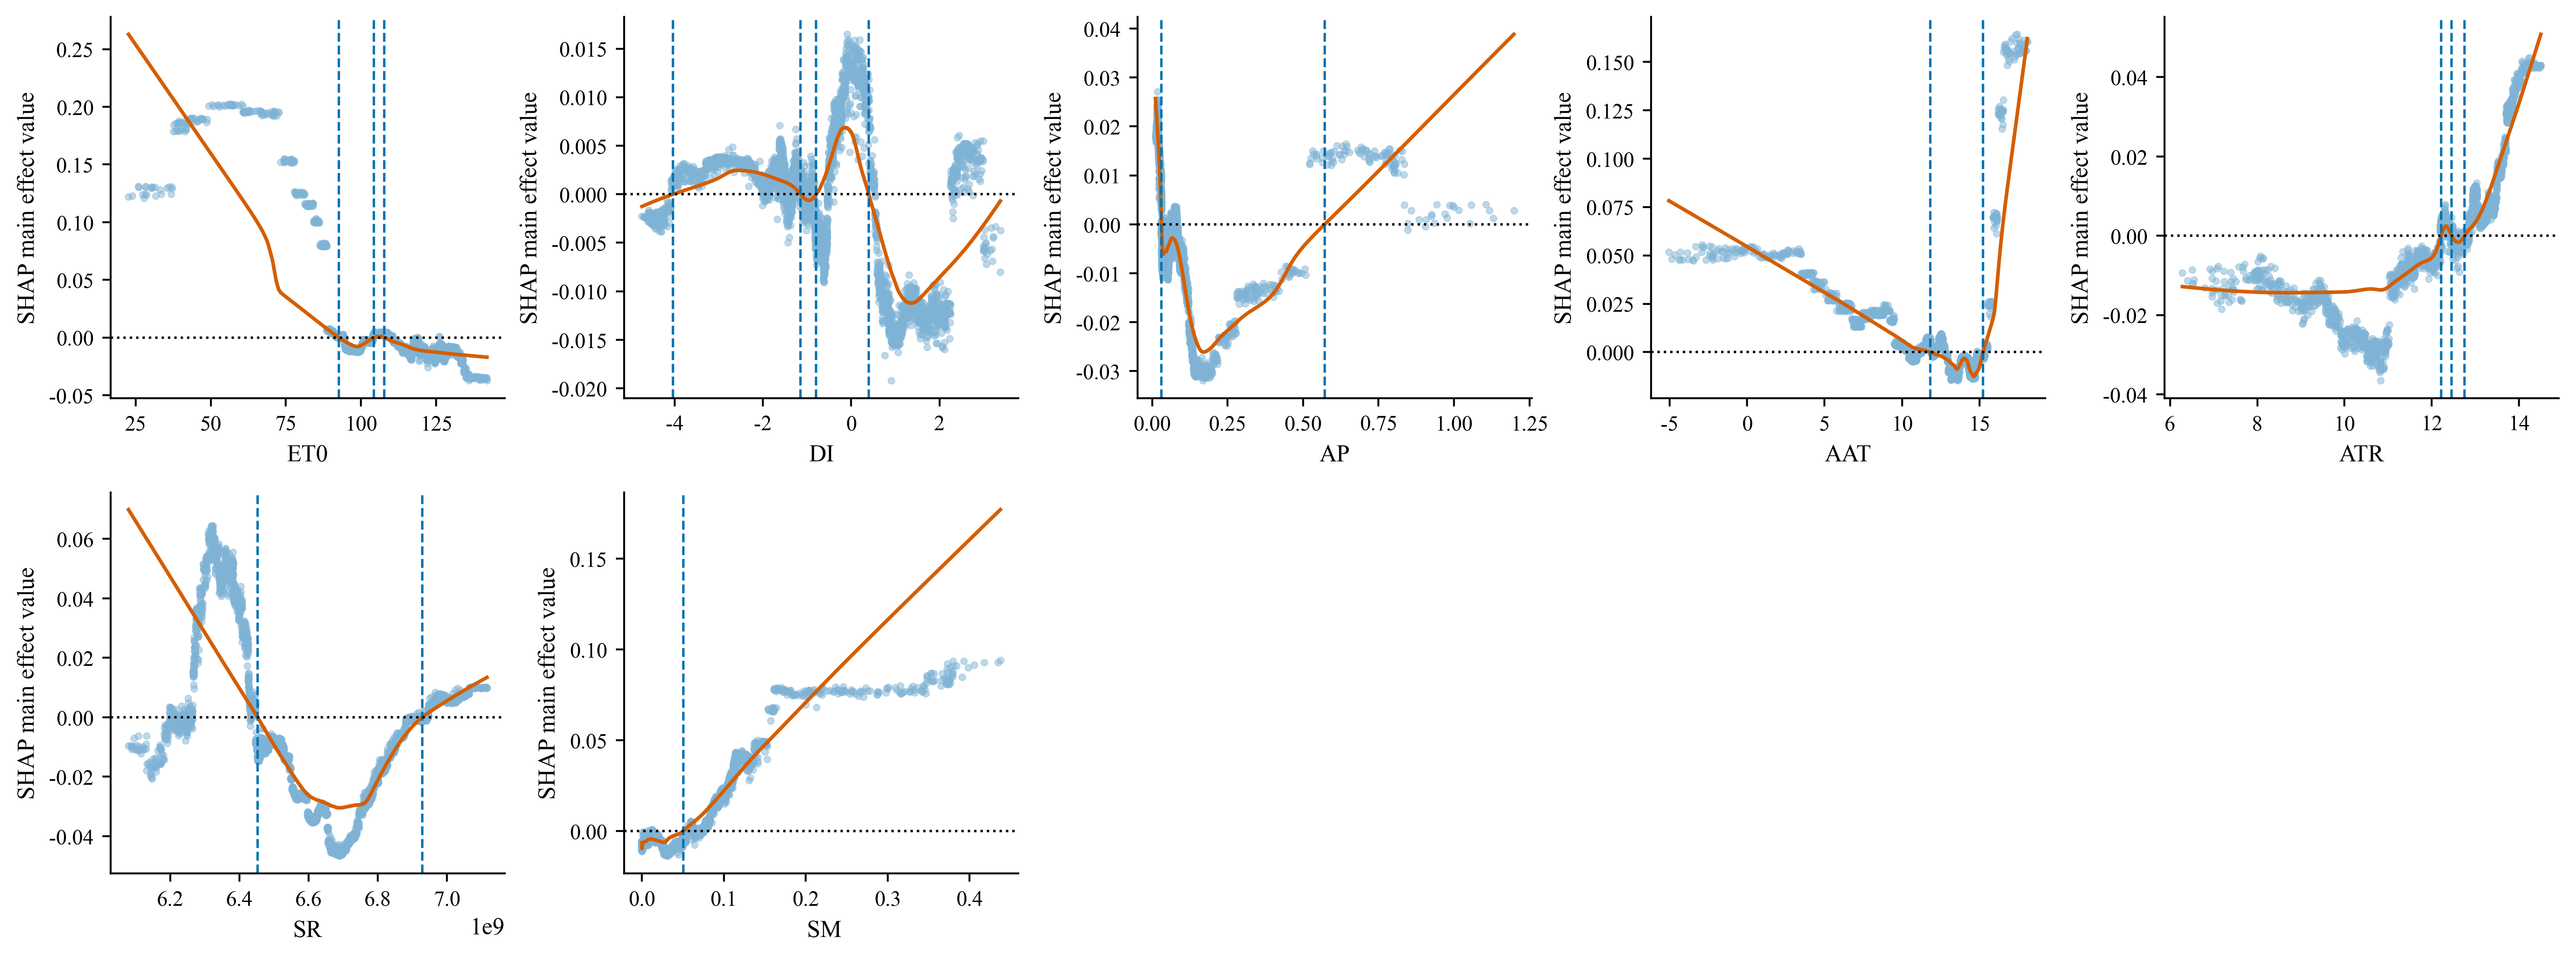

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import rcParams

# 设置全局字体与样式
plt.style.use('default')
rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.unicode_minus': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
explainer = shap.TreeExplainer(model)
# 主效应计算
shap_interaction_values = explainer.shap_interaction_values(X_train)
main_effects = np.array([shap_interaction_values[:, i, i] for i in range(shap_interaction_values.shape[1])]).T
main_effects_df = pd.DataFrame(main_effects, columns=X_train.columns)

# 子图设置
num_rows, num_cols = 3, 5
features = main_effects_df.columns[:num_rows * num_cols]
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8), dpi=400)

def find_zero_crossings(x_fit, y_fit):
    crossings = []
    for i in range(1, len(y_fit)):
        if (y_fit[i-1] < 0 and y_fit[i] > 0) or (y_fit[i-1] > 0 and y_fit[i] < 0):
            crossing = fsolve(lambda x: np.interp(x, x_fit, y_fit), x0=x_fit[i], xtol=1e-4, maxfev=100)[0]
            crossings.append(crossing)
    return crossings

# 绘制每个子图
for i, feature in enumerate(features):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]

    # 散点图
    ax.scatter(X_train[feature], main_effects_df[feature],
               s=8, c='#7FB3D5', edgecolor='#7FB3D5', alpha=0.5, linewidth=0.3)

    # LOWESS 拟合
    lowess_fit = lowess(main_effects_df[feature], X_train[feature], frac=0.4)
    x_fit = lowess_fit[:, 0]
    y_fit = lowess_fit[:, 1]
    ax.plot(x_fit, y_fit, color='#D55E00', linewidth=1.5)

    # 零交点
    x_intercepts = find_zero_crossings(x_fit, y_fit)
    for x_int in x_intercepts:
        ax.axvline(x=x_int, color='#0072B2', linestyle='--', linewidth=1)

    # 零基线
    ax.axhline(y=0, color='black', linestyle=':', linewidth=1)

    # 标签设置
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('SHAP main effect value', fontsize=10)
    ax.tick_params(axis='both', labelsize=9)

# 移除多余子图
for i in range(len(features), num_rows * num_cols):
    row, col = divmod(i, num_cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()

# 保存图像在 show 之前（避免空图）
plt.savefig("D:\\新建文件夹\\遥感\\图\\主效应图\\沙漠\\main_effects_grid_2000.png", bbox_inches='tight', dpi=400)
plt.show()


# 交互效应

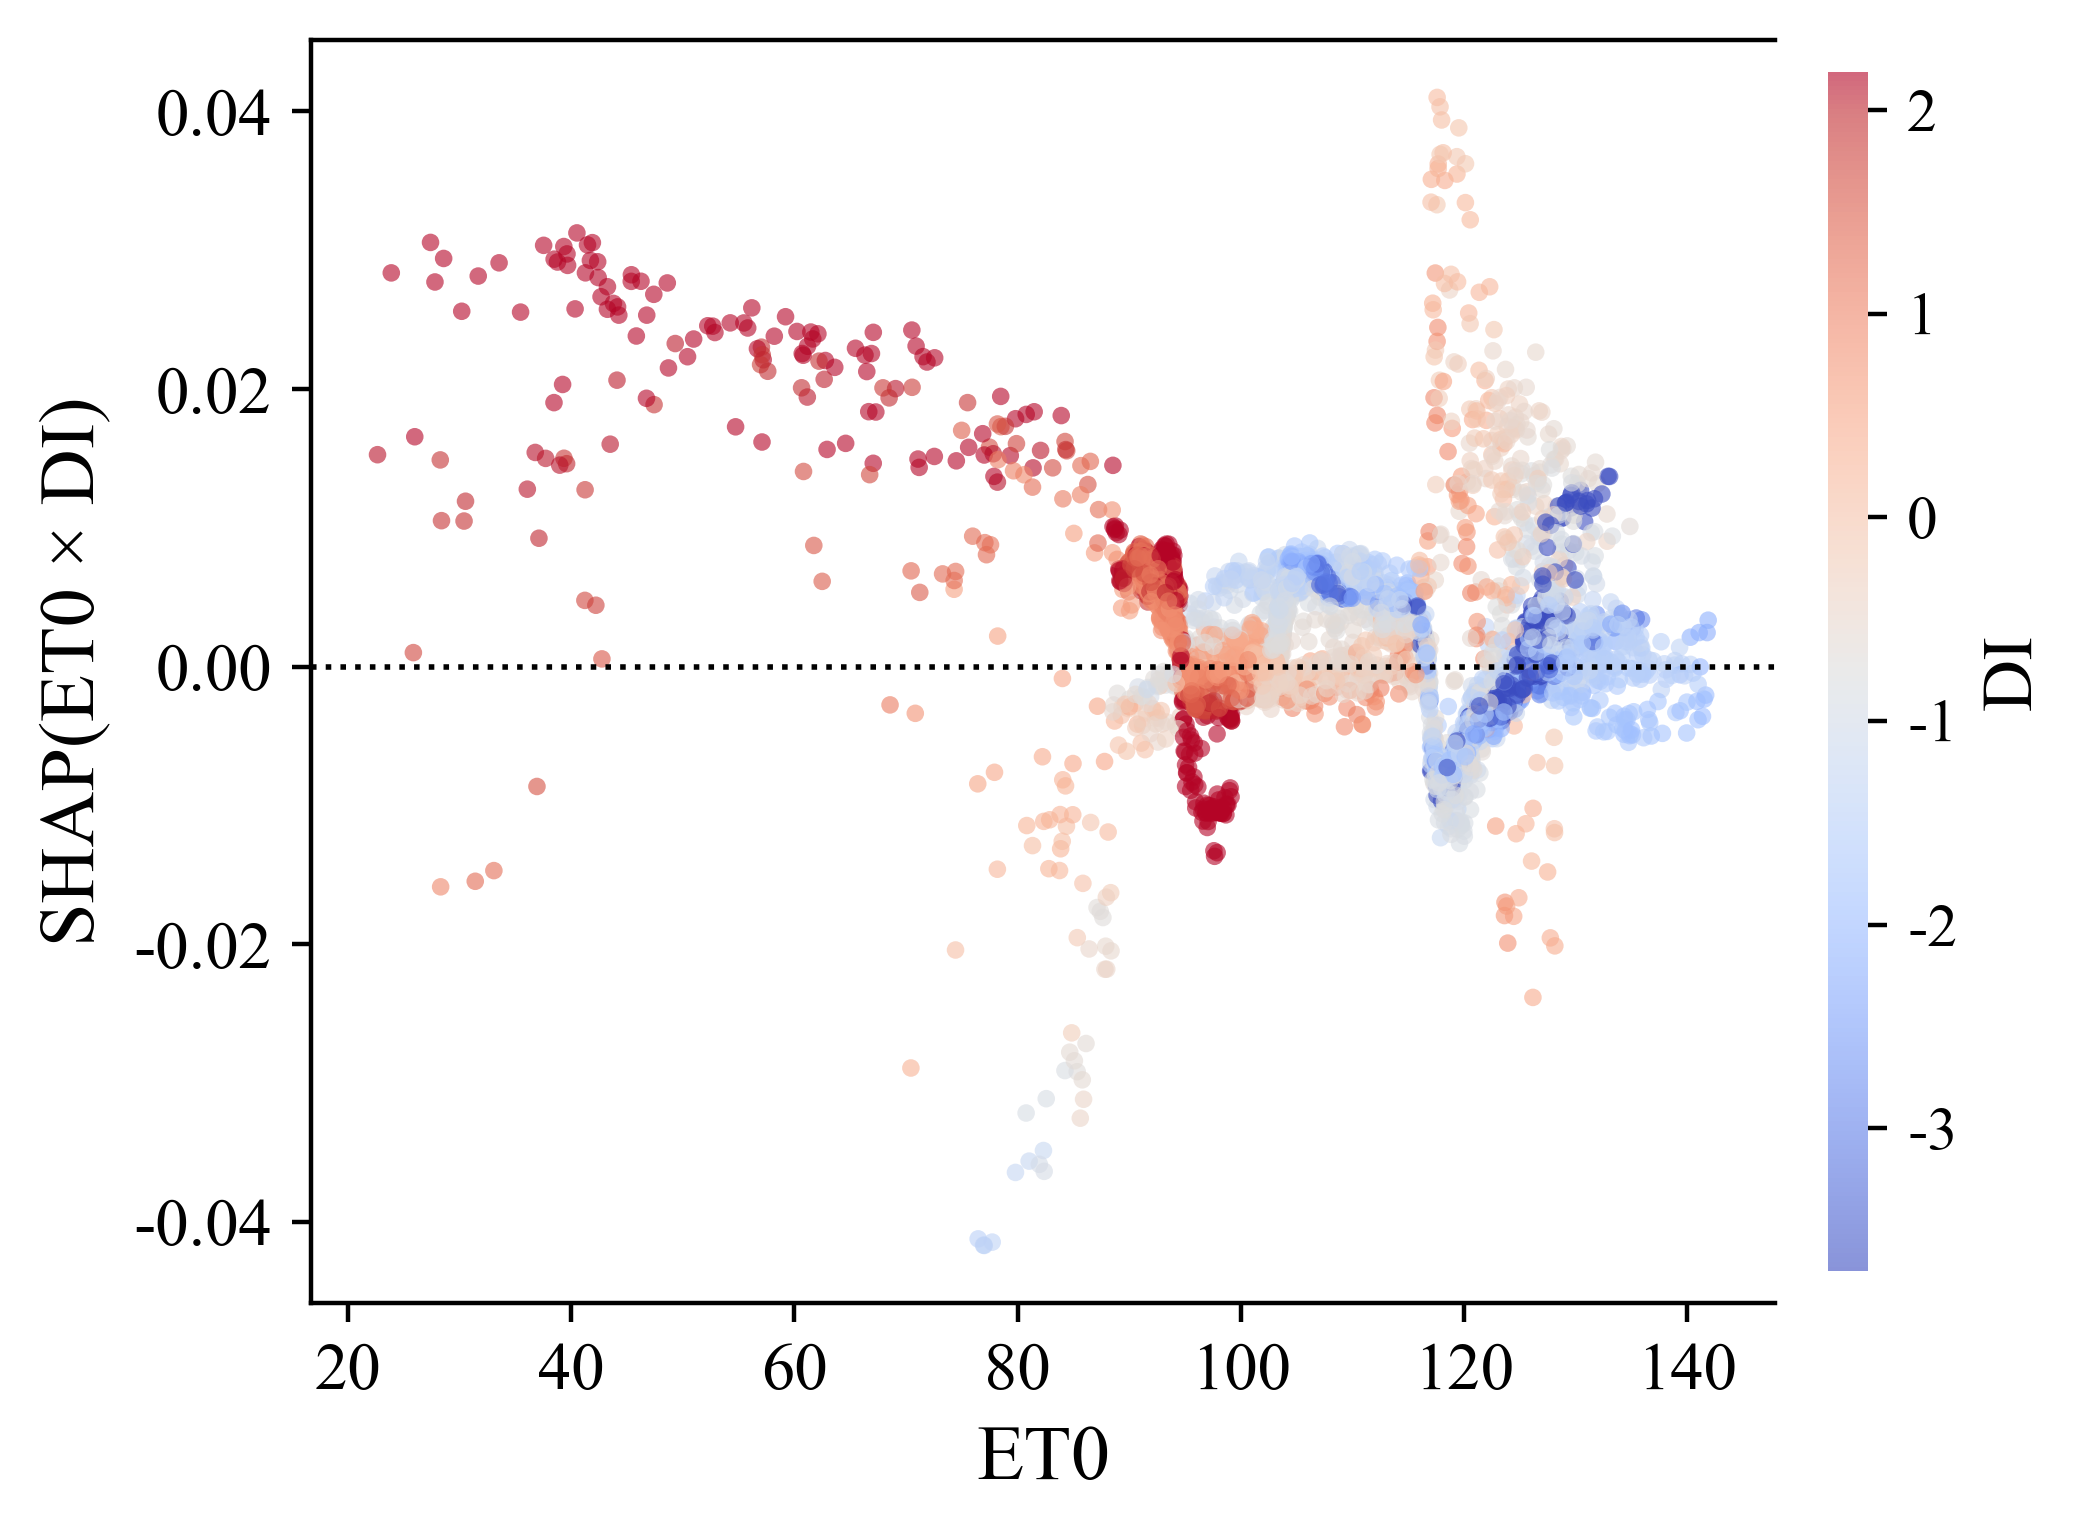

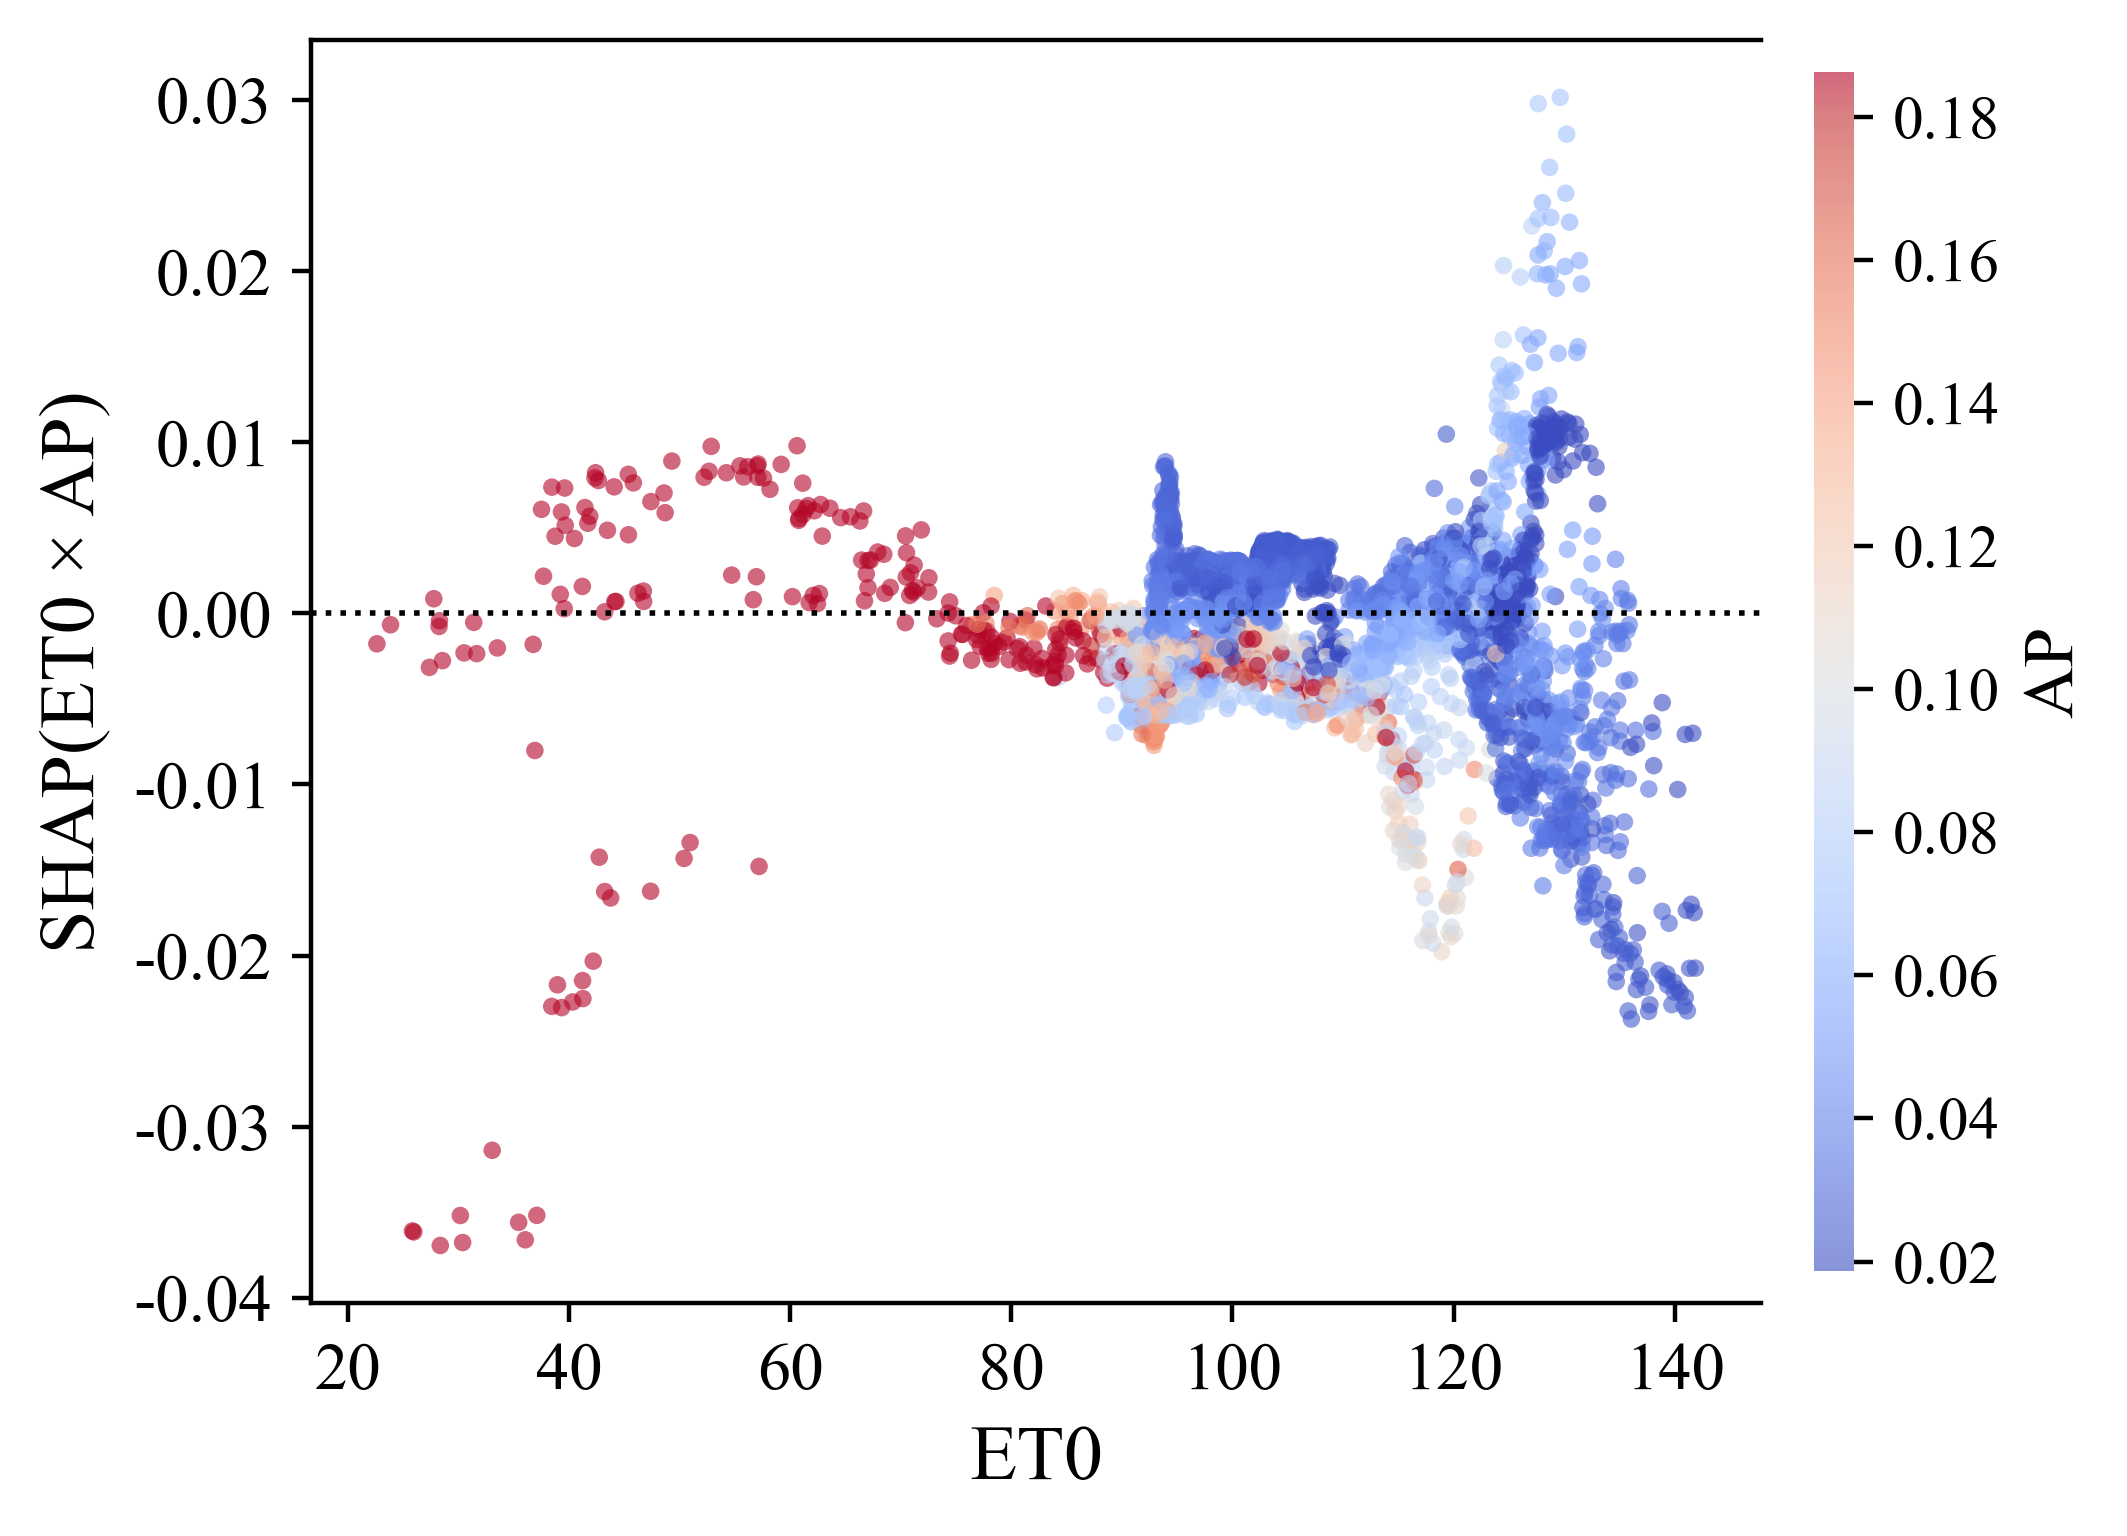

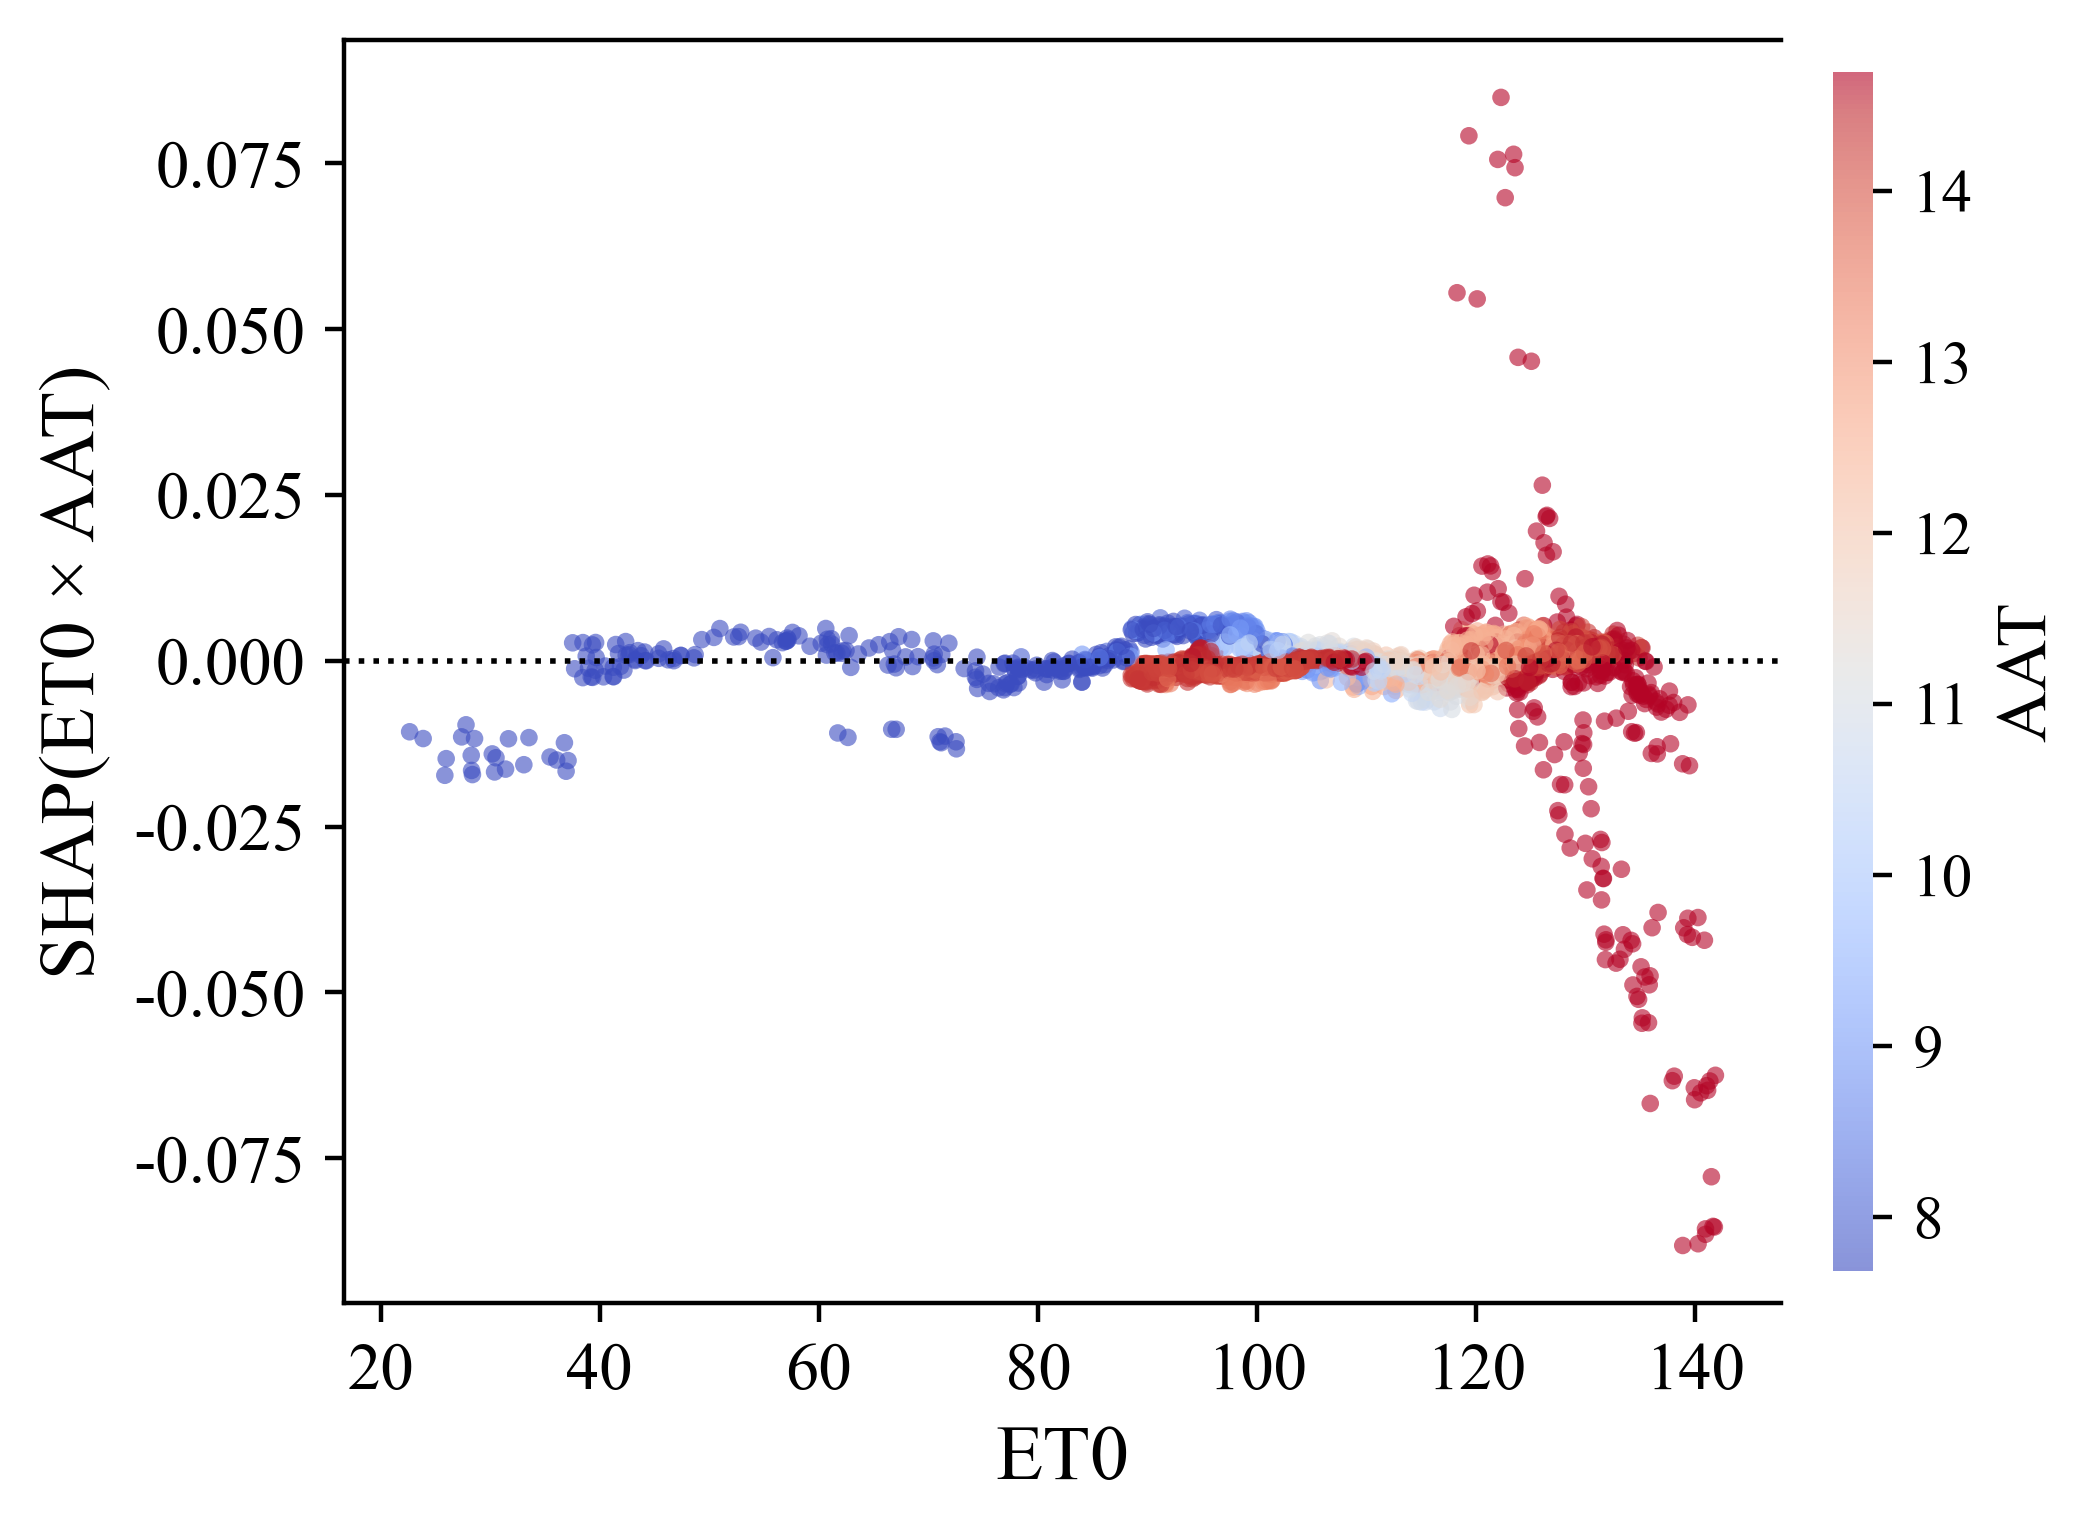

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 字体和样式配置
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.unicode_minus': False
})

# 交互图绘制
feature_names = X_train.columns
n_features = len(feature_names)

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue  # 跳过自身交互
        
        # 创建画布
        fig, ax = plt.subplots(figsize=(5.5, 4), dpi=400)

        # 获取 SHAP interaction 值（放大2倍用于对称）
        shap_values = shap_interaction_values[:, i, j] * 2
        x_data = X_train.iloc[:, i]
        color_data = X_train.iloc[:, j]

        # 控制颜色范围（去除极端值）
        vmin = np.percentile(color_data, 5)
        vmax = np.percentile(color_data, 95)

        # 绘制散点图
        sc = ax.scatter(
            x_data, shap_values,
            c=color_data,
            cmap='coolwarm',
            vmin=vmin, vmax=vmax,
            s=10, alpha=0.6,
            edgecolor='none'
        )

        # 添加色条
        cbar = plt.colorbar(sc, ax=ax, aspect=30, shrink=0.95, pad=0.03)
        cbar.set_label(feature_names[j], fontsize=13)
        cbar.ax.tick_params(labelsize=11)
        cbar.outline.set_visible(False)

        # 坐标轴设置
        ax.set_xlabel(feature_names[i], fontsize=14)
        ax.set_ylabel(f"SHAP({feature_names[i]} × {feature_names[j]})", fontsize=14)
        ax.axhline(y=0, color='black', linestyle=':', linewidth=1)

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.spines['right'].set_visible(False)

        # 保存图片（文件名包含两个特征名）
        fname = f"D:\\新建文件夹\\遥感\\图\\主效应图\\沙漠\\SHAP_{feature_names[i]}_VS_{feature_names[j]}_2001.png"
        plt.tight_layout()
        plt.savefig(fname, dpi=400, bbox_inches='tight')
        plt.show()